Load the forecasts

In [1]:
import pandas as pd

In [3]:


reverse_station_mapping = {
    433: 10384, 2667: 10513, 3379: 10865, 1443: 10803, 
    5906: 10729, 2522: 10727, 4104: 10776, 1270: 10554, 
    5419: 10555
}

valid_stations = [
    reverse_station_mapping[station] for station in [433, 1270, 1443, 2667, 3379, 4104, 5906]
]

df_forecasts = pd.read_csv("../data/merged.csv")
df_forecasts = df_forecasts[df_forecasts["station_id"].isin(valid_stations)]
df_forecasts["recorded_at"] = pd.to_datetime(df_forecasts["recorded_at"], utc=True)
df_forecasts["recorded_at"] = df_forecasts["recorded_at"].dt.floor('h')
df_forecasts["forecast_time"] = pd.to_datetime(df_forecasts["forecast_time"], utc=True)
df_forecasts.head()

,recorded_at,station_id,forecast_time,parameter,value
0,2024-05-12 15:00:00+00:00,10513,2024-05-12 15:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0
1,2024-05-12 15:00:00+00:00,10513,2024-05-12 16:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0
2,2024-05-12 15:00:00+00:00,10513,2024-05-12 17:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0
3,2024-05-12 15:00:00+00:00,10513,2024-05-12 18:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0
4,2024-05-12 15:00:00+00:00,10513,2024-05-12 19:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0


Load the actual weather

In [5]:
df_measure = pd.read_csv("../data/historical_weather.csv")
df_measure["recorded_at"] = pd.to_datetime(df_measure["recorded_at"], utc=True)
df_measure.head()

,recorded_at,station_id,parameter,value
0,2024-05-06 00:00:00+00:00,433,precipitation_height,0.0
1,2024-05-06 01:00:00+00:00,433,precipitation_height,0.0
2,2024-05-06 02:00:00+00:00,433,precipitation_height,0.0
3,2024-05-06 03:00:00+00:00,433,precipitation_height,0.0
4,2024-05-06 04:00:00+00:00,433,precipitation_height,0.0


Mapping from forecast to measurement

In [6]:
reverse_parameter_mapping = {
    'precipitation_height': 'precipitation_height_significant_weather_last_1h',
    'temperature_air_mean_2m': 'temperature_air_mean_200'
}

In [7]:
from tqdm import tqdm

rows_regression = []
rows = df_measure[
  (df_measure["recorded_at"].dt.dayofyear == 200) &
  (df_measure["parameter"] == "temperature_air_mean_2m")
]

measure_times = rows.recorded_at.unique().tolist()

rows_measure_time = []

parameter = "temperature_air_mean_2m"

for measure_time in measure_times:
    forecast_rows_measure_time = df_forecasts[
        (df_forecasts["forecast_time"] == measure_time) &
        (df_forecasts["parameter"] == reverse_parameter_mapping[parameter])
    ]

    rows_measure_time.append(forecast_rows_measure_time.groupby(forecast_rows_measure_time.recorded_at).value.mean().mean())

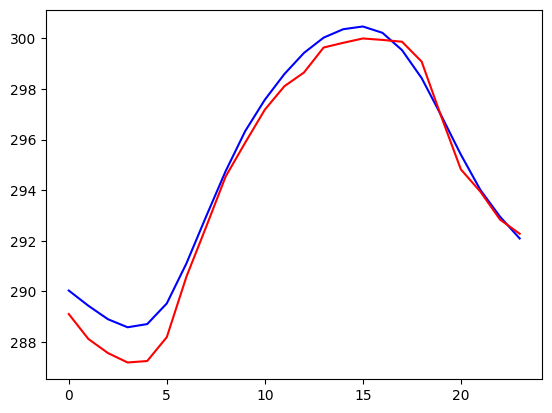

In [8]:
import matplotlib.pyplot as plt

y = rows.groupby(rows.recorded_at.dt.hour).value.mean().to_numpy()
plt.plot(rows_measure_time, c="b")
plt.plot(y, c="r")
plt.show()

In [9]:
from scipy import stats

stats.linregress(rows_measure_time, y)

LinregressResult(slope=1.0802627304025387, intercept=-24.179048940134237, rvalue=0.9954841922702458, pvalue=5.3730088620892214e-24, stderr=0.021962185311337354, intercept_stderr=6.4761459292756)

In [ ]:
#for measure_time in measure_times:
#    parameter = "temperature_air_mean_2m"

#    forecast_rows_measure_time = df_forecasts[
#        (df_forecasts["forecast_time"] == measure_time) &
#        (df_forecasts["parameter"] == reverse_parameter_mapping[parameter])
#    ]

    # (240 * stations)
#    values = forecast_rows_measure_time.groupby([
#        forecast_rows_measure_time.recorded_at.dt.dayofyear,
#        forecast_rows_measure_time.recorded_at.dt.hour
#    ]).value.mean()

#    rows_regression.append(values.tolist())

R^2 Score: 0.9864806318159318
Coefficients: [1.07284893]
Intercept: -22.03263366411295


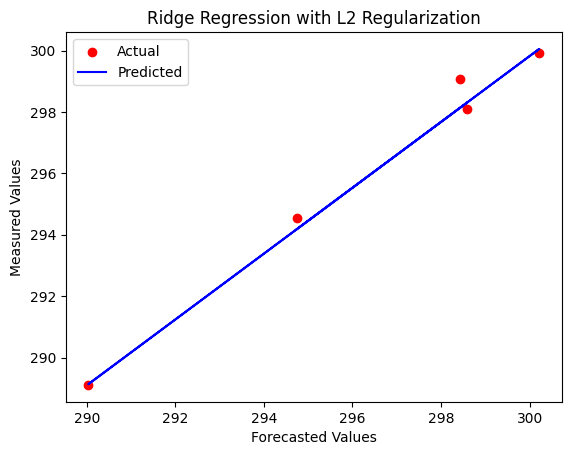

In [10]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare the features (forecast data) and target (actual measurement data)
X = np.array(rows_measure_time).reshape(-1, 1)  # Reshape for sklearn
y = rows.groupby(rows.recorded_at.dt.hour).value.mean().to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Ridge Regression (L2 Regularization)
ridge = Ridge(alpha=1.0)  # Alpha is the regularization strength
ridge.fit(X_train, y_train)

# Predictions
y_pred = ridge.predict(X_test)

# Evaluate the model
print(f"R^2 Score: {ridge.score(X_test, y_test)}")
print(f"Coefficients: {ridge.coef_}")
print(f"Intercept: {ridge.intercept_}")

# Visualize the results
import matplotlib.pyplot as plt

plt.scatter(X_test, y_test, color='red', label='Actual')
plt.plot(X_test, y_pred, color='blue', label='Predicted')
plt.legend()
plt.xlabel("Forecasted Values")
plt.ylabel("Measured Values")
plt.title("Ridge Regression with L2 Regularization")
plt.show()


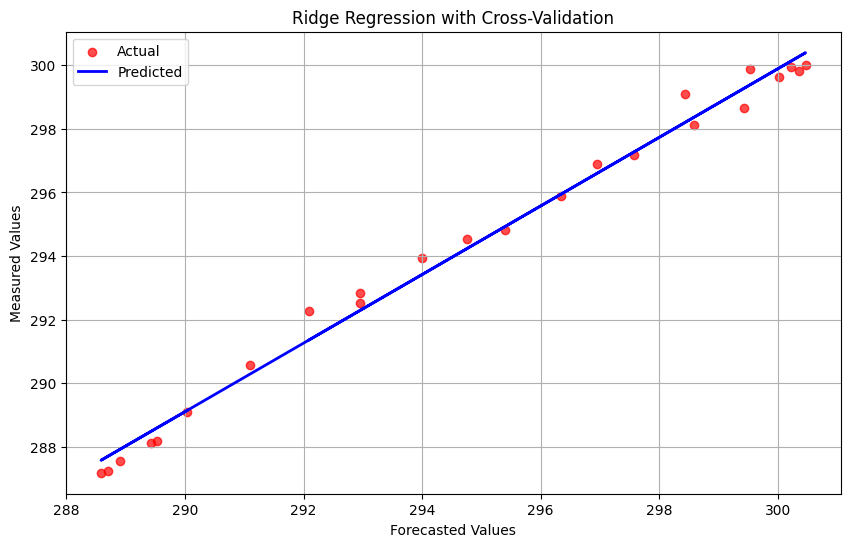

(0.9820411988319453, 0.015656131229860655)

In [11]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data for cross-validation
X = np.array(rows_measure_time).reshape(-1, 1)  # Reshape for sklearn compatibility
y = rows.groupby(rows.recorded_at.dt.hour).value.mean().to_numpy()

# Define the Ridge regression model with L2 regularization
ridge = Ridge(alpha=1.0)  # Regularization strength

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(ridge, X, y, cv=kf, scoring='r2')

# Train the model on the entire dataset for visualization
ridge.fit(X, y)
y_pred = ridge.predict(X)

# Plot the data and predictions
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='red', label='Actual', alpha=0.7)
plt.plot(X, y_pred, color='blue', label='Predicted', linewidth=2)
plt.title("Ridge Regression with Cross-Validation")
plt.xlabel("Forecasted Values")
plt.ylabel("Measured Values")
plt.legend()
plt.grid(True)
plt.show()

# Display cross-validation results
cv_mean_score = np.mean(cv_scores)
cv_std_score = np.std(cv_scores)

cv_mean_score, cv_std_score
